# Table of Contents <a class = "anchor" id = "toc"></a>
* [Data Importation](#data_impo)
* [Classification Models](#models)
* [Evaluation](#model_eval)

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('opinion_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pickle

from tqdm import tqdm
from gensim.models import Word2Vec

from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report, auc, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.models import Model

from sentence_transformers import SentenceTransformer
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import emoji
import langid
import regex
import string

import re
from tqdm import tqdm
import regex
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import hstack
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import joblib

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Importation <a class = "anchor" id = "data_impo"></a>
[Back to the Table of Contents](#toc)

In [2]:
X_combined_tfidf = joblib.load('../project_data/X_combined_tfidf.joblib')
y=  joblib.load('../project_data/y.joblib')

combined_embeddings_labse= joblib.load('../project_data/combined_embeddings_labse.joblib')
y_array = joblib.load('../project_data/y_array.joblib')

X_train = joblib.load('../project_data/X_train.joblib')
X_val = joblib.load('../project_data/X_val.joblib')
y_train = joblib.load('../project_data/y_train.joblib')
y_val = joblib.load('../project_data/y_val.joblib')

# Classification Models - Model Testing  <a class = "anchor" id = "models"></a>
[Back to the Table of Contents](#toc)

## Model testing with TF-IDF

### Logistic Regression - sklearn  (using TF-IDF)

This approach involves performing hyperparameter tuning using a randomized search with cross-validation for three different logistic regression models. Each logistic regression model has different hyperparameters defined in the hyperparameters list. Here's an explanation of each part:

**Models:** Three logistic regression models are defined with different settings for the solver parameter. This allows you to explore how different solvers perform with different hyperparameters.

**Hyperparameters:** For each logistic regression model, a dictionary of hyperparameters is defined. These hyperparameters will be tuned during the randomized search. Each dictionary contains different combinations of hyperparameters to explore.

**Cross-validation:** Stratified k-fold cross-validation is used to evaluate the performance of each model and hyperparameter combination. It ensures that each fold preserves the percentage of samples for each class. as we are using on all the project

**Randomized Search:** For each model, a RandomizedSearchCV object is created. It performs a randomized search over the hyperparameter space defined in the corresponding hyperparameters dictionary. The scoring parameter is set to 'f1', indicating that the F1 score will be used as the evaluation metric.

**Results:** After the randomized search is complete for each model, the best score and best parameters are recorded in a DataFrame named test_scores_lg. This DataFrame contains the performance of each model along with the corresponding best hyperparameters.

In [ ]:
models = [
    LogisticRegression(class_weight='balanced', random_state=42, solver='saga'),
    LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'),
    LogisticRegression(class_weight='balanced', random_state=42, solver='saga')
]


hyperparameters = [
    {
        'model__penalty': ['l2'],
        'model__C': np.logspace(-2, 2, 50) 
    },
    {
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-2, 2, 50)  
    },
    {
        'model__penalty': ['l1','elasticnet'],
        'model__C': np.logspace(-2, 2, 50),  
        'model__l1_ratio': [0.1, 0.5, 0.9]  
    }
]

# Initialize cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)

results = []
cv_results_dfs = []

# Loop through each model and its hyperparameters
for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([('model', model)])

    # Perform random search
    rs = RandomizedSearchCV(pipeline, params, cv=stratified_kfold, n_iter=10, scoring='f1', verbose=10)
    rs.fit(X_combined_tfidf, y)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

# Create DataFrame with results
test_scores_lg_tfidf = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_lg_tfidf = test_scores_lg_tfidf.sort_values('best_score', ascending=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__C=10.481131341546853, model__penalty=l2.............
[CV 1/5; 1/10] END model__C=10.481131341546853, model__penalty=l2;, score=0.812 total time=   1.8s
[CV 2/5; 1/10] START model__C=10.481131341546853, model__penalty=l2.............
[CV 2/5; 1/10] END model__C=10.481131341546853, model__penalty=l2;, score=0.789 total time=   1.7s
[CV 3/5; 1/10] START model__C=10.481131341546853, model__penalty=l2.............
[CV 3/5; 1/10] END model__C=10.481131341546853, model__penalty=l2;, score=0.807 total time=   1.7s
[CV 4/5; 1/10] START model__C=10.481131341546853, model__penalty=l2.............
[CV 4/5; 1/10] END model__C=10.481131341546853, model__penalty=l2;, score=0.797 total time=   1.7s
[CV 5/5; 1/10] START model__C=10.481131341546853, model__penalty=l2.............
[CV 5/5; 1/10] END model__C=10.481131341546853, model__penalty=l2;, score=0.793 total time=   1.7s
[CV 1/5; 2/10] START model__C=0.1389495

In [ ]:
test_scores_lg_tfidf

In [ ]:
print(test_scores_lg_tfidf['best_params'][1])
print(test_scores_lg_tfidf['best_score'][1])

In [ ]:
print(test_scores_lg_tfidf['best_params'][2])
print(test_scores_lg_tfidf['best_score'][2])

In [ ]:
print(test_scores_lg_tfidf['best_params'][0])
print(test_scores_lg_tfidf['best_score'][0])

### KNN - sklearn  (using TF-IDF)

In [ ]:
knn_model = KNeighborsClassifier()

# Define the hyperparameters for randomized search
hyperparameters = {
    'n_neighbors': range(1, 31),  # Test range of neighbors from 1 to 20
    'weights': ['uniform', 'distance'],  # Test uniform and distance-based weights
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithms for computing neighbors
    'p': [1, 2]  # Parameter for distance metric (1 for Manhattan, 2 for Euclidean)
}

# Set up randomized search with cross-validation
rs = RandomizedSearchCV(knn_model, hyperparameters, cv=stratified_kfold, n_iter=40, scoring='f1', verbose=10)

# Perform the randomized search for best hyperparameters
rs.fit(X_combined_tfidf, y)

# Extract the results
best_params_knn = rs.best_params_
best_score_knn = rs.best_score_

In [ ]:
# Display the best parameters and F1 score
print("Best parameters:", best_params_knn)
print("Best F1 Score:", best_score_knn)

### MLP - sklearn  (using TF-IDF)

In [ ]:
models = [
    ('MLP', MLPClassifier(random_state=42))
]
  
hyperparameters = [
    {
        'MLP__hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
        'MLP__activation': ['tanh', 'relu'],
        'MLP__solver': ['sgd', 'adam'],
        'MLP__learning_rate': ['constant', 'invscaling', 'adaptive'],
        'MLP__alpha': np.logspace(-4, 4, 100),
        'MLP__learning_rate_init': [0.001,0.01],
        'MLP__max_iter': np.arange(100, 300),
        'MLP__batch_size': np.arange(50, 150)
    }
]

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = []
cv_results_dfs = []

for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([model])
    
    rs = RandomizedSearchCV(pipeline, params, cv=stratified_kfold, n_iter=20, scoring='f1', verbose=10)
    rs.fit(X_combined_tfidf, y)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

test_scores_mlp_tfidf = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_mlp_tfidf = test_scores_mlp_tfidf.sort_values('best_score', ascending=False)

In [ ]:
test_scores_mlp_tfidf

In [ ]:
print(test_scores_mlp_tfidf['best_params'][0])
print(test_scores_mlp_tfidf['best_score'][0])

### XGBoost  (using  TF-IDF)

In [ ]:
models = [
    ('XGBoost', XGBClassifier(random_state=19, objective='binary:logistic', eval_metric='logloss'))
]

hyperparameters = [
    {
        'XGBoost__n_estimators': [300, 350, 400],
        'XGBoost__max_depth': [15, 20, 25],
        'XGBoost__subsample': [1.0],
        'XGBoost__min_child_weight': [1, 5, 10],
        'XGBoost__learning_rate': [0.01, 0.1, 1.0]
    }
]

stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=19)

results = []
cv_results_dfs = []

for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([model])
    
    rs = RandomizedSearchCV(pipeline, params, n_iter= 30, cv=stratified_kfold, scoring='f1', verbose=10)
    rs.fit(X_combined_tfidf, y)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

test_scores_xgb = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_xgb = test_scores_xgb.sort_values('best_score', ascending=False)

In [ ]:
test_scores_xgb

In [ ]:
print(test_scores_xgb['best_params'][0])
print(test_scores_xgb['best_score'][0])

## Model testing with LaBSE embedings

### Logistic Regression - sklearn  (using labse embeddings)

This approach involves performing hyperparameter tuning using a randomized search with cross-validation for three different logistic regression models. Each logistic regression model has different hyperparameters defined in the hyperparameters list. Here's an explanation of each part:

**Models:** Three logistic regression models are defined with different settings for the solver parameter. This allows you to explore how different solvers perform with different hyperparameters.

**Hyperparameters:** For each logistic regression model, a dictionary of hyperparameters is defined. These hyperparameters will be tuned during the randomized search. Each dictionary contains different combinations of hyperparameters to explore.

**Cross-validation:** Stratified k-fold cross-validation is used to evaluate the performance of each model and hyperparameter combination. It ensures that each fold preserves the percentage of samples for each class. as we are using on all the project

**Randomized Search:** For each model, a RandomizedSearchCV object is created. It performs a randomized search over the hyperparameter space defined in the corresponding hyperparameters dictionary. The scoring parameter is set to 'f1', indicating that the F1 score will be used as the evaluation metric.

**Results:** After the randomized search is complete for each model, the best score and best parameters are recorded in a DataFrame named test_scores_lg. This DataFrame contains the performance of each model along with the corresponding best hyperparameters.

In [ ]:
models = [
    LogisticRegression(class_weight='balanced', random_state=42, solver='saga'),
    LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'),
    LogisticRegression(class_weight='balanced', random_state=42, solver='saga')
]


hyperparameters = [
    {
        'model__penalty': ['l2'],
        'model__C': np.logspace(-2, 2, 50) 
    },
    {
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-2, 2, 50)  
    },
    {
        'model__penalty': ['l1','elasticnet'],
        'model__C': np.logspace(-2, 2, 50),  
        'model__l1_ratio': [0.1, 0.5, 0.9]  
    }
]

# Initialize cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)

results = []
cv_results_dfs = []

# Loop through each model and its hyperparameters
for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([('model', model)])

    # Perform random search
    rs = RandomizedSearchCV(pipeline, params, cv=stratified_kfold, n_iter=10, scoring='f1', verbose=10)
    rs.fit(combined_embeddings_labse, y_array)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

# Create DataFrame with results
test_scores_lg1 = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_lg1 = test_scores_lg1.sort_values('best_score', ascending=False)

In [ ]:
test_scores_lg1

In [ ]:
print(test_scores_lg1['best_params'][1])
print(test_scores_lg1['best_score'][1])

In [ ]:
print(test_scores_lg1['best_params'][2])
print(test_scores_lg1['best_score'][2])

In [ ]:
print(test_scores_lg1['best_params'][0])
print(test_scores_lg1['best_score'][0])

### KNN - sklearn  (using labse embeddings)

In [ ]:
nn_model = KNeighborsClassifier()

# Define the hyperparameters for randomized search
hyperparameters = {
    'n_neighbors': range(1, 31),  # Test range of neighbors from 1 to 20
    'weights': ['uniform', 'distance'],  # Test uniform and distance-based weights
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithms for computing neighbors
    'p': [1, 2]  # Parameter for distance metric (1 for Manhattan, 2 for Euclidean)
}

# Set up randomized search with cross-validation
rs = RandomizedSearchCV(knn_model, hyperparameters, cv=stratified_kfold, n_iter=40, scoring='f1', verbose=10)

# Perform the randomized search for best hyperparameters
rs.fit(combined_embeddings_labse, y_array)

# Extract the results
best_params_knn = rs.best_params_
best_score_knn = rs.best_score_

In [ ]:
# Display the best parameters and F1 score
print("Best parameters:", best_params_knn)
print("Best F1 Score:", best_score_knn)

### MLP - sklearn  (using labse embeddings)

**Approach 2:**

**Model:** Utilizes a scikit-learn MLPClassifier.\
**Hyperparameter Tuning:** Performs hyperparameter tuning using Randomized Search Cross Validation (RandomizedSearchCV).\
**Hyperparameters:** Searches through a predefined set of hyperparameters for the MLPClassifier using a randomized search strategy.\
**Evaluation:** Collects and analyzes the results of hyperparameter tuning, including the best score and best parameters found during the search.

In [ ]:
models = [
    ('MLP', MLPClassifier(random_state=42))
]
  
hyperparameters = [
    {
        'MLP__hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
        'MLP__activation': ['tanh', 'relu'],
        'MLP__solver': ['sgd', 'adam'],
        'MLP__learning_rate': ['constant', 'invscaling', 'adaptive'],
        'MLP__alpha': np.logspace(-4, 4, 100),
        'MLP__learning_rate_init': [0.001,0.01],
        'MLP__max_iter': np.arange(100, 300),
        'MLP__batch_size': np.arange(50, 150)
    }
]

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
cv_results_dfs = []

for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([model])
    
    rs = RandomizedSearchCV(pipeline, params, cv=stratified_kfold, n_iter=10, scoring='f1', verbose=10)
    rs.fit(combined_embeddings_labse, y_array)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

test_scores_mlp = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_mlp = test_scores_mlp.sort_values('best_score', ascending=False)

In [ ]:
test_scores_mlp

In [ ]:
print(test_scores_mlp['best_params'][0])
print(test_scores_mlp['best_score'][0])

### XGBoost  (using LaBSE embeddings)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

models = [
    ('XGBoost', XGBClassifier(random_state=19, objective='binary:logistic', eval_metric='logloss'))
]

hyperparameters = [
    {
        'XGBoost__n_estimators': [360, 370, 380],
        'XGBoost__max_depth': [15, 17, 20],
        'XGBoost__subsample': [1.0],
        'XGBoost__min_child_weight': [1, 5, 10],
        'XGBoost__learning_rate': [0.01, 0.1, 1.0]
    }
]

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)

results = []
cv_results_dfs = []

for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([model])
    
    rs = GridSearchCV(pipeline, params, cv=stratified_kfold, scoring='f1', verbose=10)
    rs.fit(combined_embeddings_labse, y_array)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

test_scores_xgb = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_xgb = test_scores_xgb.sort_values('best_score', ascending=False)

In [ ]:
test_scores_xgb

In [ ]:
print(test_scores_xgb['best_params'][0])
print(test_scores_xgb['best_score'][0])

## DistilBERT - Transformer (for model testing) 

In [ ]:
y_train = y_train.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

In [ ]:
def prepare_data(X, y):
    data = pd.DataFrame({
        'text': X['cleaned_comments'] + ' [SEP] ' + X['cleaned_host'] + ' [SEP] ' + X['cleaned_description'],
        'label': y
    })
    return data

In [ ]:
train_data = prepare_data(X_train, y_train)
val_data = prepare_data(X_val, y_val)

In [ ]:
class BinaryClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data['text'][index])
        label = self.data['label'][index]
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

max_length = 512  # Increase max_length to 512

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,  # Increase epochs to 8
    per_device_train_batch_size=16,  # Adjust batch size
    per_device_eval_batch_size=16,  # Adjust batch size
    warmup_steps=1000,  # Increase warm-up steps
    weight_decay=0.001,  # Adjust weight decay
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
)

# Define compute_metrics function (same as before)

# Initialize Trainer
trainer = Trainer(
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate on validation set
results = trainer.evaluate()

print("Validation Results:")
for key, value in results.items():
    print(f"{key}: {value}")

In [ ]:
# Predictions on validation set
val_predictions = trainer.predict(val_dataset)
val_y_true = val_predictions.label_ids
val_y_pred = val_predictions.predictions.argmax(axis=-1)

In [ ]:
# Classification report for validation set
print(classification_report(val_y_true, val_y_pred))

In [ ]:
# Compute ROC curve for the transformer
fpr_transformer, tpr_transformer, _ = roc_curve(val_y_true, val_predictions.predictions[:, 1])
roc_auc_transformer = auc(fpr_transformer, tpr_transformer)

In [ ]:
f1_distilbert = f1_score(val_y_true, val_y_pred)
accuracy_distilbert = accuracy_score(val_y_true, val_y_pred)
roc_distilbert = roc_auc_score(val_y_true, val_y_pred)
precision_distilbert = precision_score(val_y_true, val_y_pred)
recall_distilbert = recall_score(val_y_true, val_y_pred)

In [ ]:
# Fit vectorizers on the training data
tfidf_vectorizer1 = TfidfVectorizer().fit(X_train['cleaned_comments'])
tfidf_vectorizer2 = TfidfVectorizer().fit(X_train['cleaned_host'])
tfidf_vectorizer3 = TfidfVectorizer().fit(X_train['cleaned_description'])

# Transform the training data
X1_tfidf_train = tfidf_vectorizer1.transform(X_train['cleaned_comments'])
X2_tfidf_train = tfidf_vectorizer2.transform(X_train['cleaned_host'])
X3_tfidf_train = tfidf_vectorizer3.transform(X_train['cleaned_description'])

# Combine TF-IDF features for the training data
X_combined_tfidf_train = hstack([X1_tfidf_train, X2_tfidf_train, X3_tfidf_train])

# Transform the validation data using the same vectorizers
X1_tfidf_val = tfidf_vectorizer1.transform(X_val['cleaned_comments'])
X2_tfidf_val = tfidf_vectorizer2.transform(X_val['cleaned_host'])
X3_tfidf_val = tfidf_vectorizer3.transform(X_val['cleaned_description'])

# Combine TF-IDF features for the validation data
X_combined_tfidf_val = hstack([X1_tfidf_val, X2_tfidf_val, X3_tfidf_val])

# Ensure that the number of features match
print(X_combined_tfidf_train.shape)  # Should output: (4686, 162797)
print(X_combined_tfidf_val.shape)

# Classification Models - Model Evaluation  <a class = "anchor" id = "models_eval"></a>
[Back to the Table of Contents](#toc)

## Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix
def final_metrics(y_data, y_pred):
    print('___________________________________________________________________________________________________________')
    print('                              Classification Report & Confusion Matrix                                     ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_data, y_pred))
    print(confusion_matrix(y_data, y_pred))

### Logistic Regression

In [ ]:
lg_model = LogisticRegression(C=8.68511373751352, penalty='l2', solver='saga', random_state=42)

lg_model.fit(X_combined_tfidf_train, y_train)

y_train_pred = lg_model.predict(X_combined_tfidf_train)
y_val_pred = lg_model.predict(X_combined_tfidf_val)


train_f1_score = f1_score(y_train, y_train_pred)
test_f1_score = f1_score(y_val, y_val_pred)

print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)

In [ ]:
# Classification report for training data
print("Classification Report for Training Data:")
print(final_metrics(y_train, y_train_pred))

In [ ]:
# Classification report for validation data
print("Classification Report for Validation Data:")
print(final_metrics(y_val, y_val_pred))

In [609]:
f1_logit = f1_score(y_val, y_val_pred)
accuracy_logit = accuracy_score(y_val, y_val_pred)
roc_logit = roc_auc_score(y_val, y_val_pred)
precision_logit = precision_score(y_val, y_val_pred)
recall_logit = recall_score(y_val, y_val_pred)

### KNN Classifier

In [610]:
knn_model = KNeighborsClassifier(weights= 'distance', p=2, n_neighbors= 25, algorithm= 'auto')

knn_model.fit(X_combined_tfidf_train, y_train)

y_train_pred = knn_model.predict(X_combined_tfidf_train)
y_val_pred = knn_model.predict(X_combined_tfidf_val)


train_f1_score = f1_score(y_train, y_train_pred)
test_f1_score = f1_score(y_val, y_val_pred)

print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)

Training F1 Score: 0.9988285825849278
Testing F1 Score: 0.7899343544857768


In [611]:
# Classification report for training data
print("Classification Report for Training Data:")
print(final_metrics(y_train, y_train_pred))

Classification Report for Training Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3405
           1       1.00      1.00      1.00      1281

    accuracy                           1.00      4686
   macro avg       1.00      1.00      1.00      4686
weighted avg       1.00      1.00      1.00      4686

[[3404    1]
 [   2 1279]]
None


In [612]:
# Classification report for validation data
print("Classification Report for Validation Data:")
print(final_metrics(y_val, y_val_pred))

Classification Report for Validation Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1135
           1       0.74      0.85      0.79       427

    accuracy                           0.88      1562
   macro avg       0.84      0.87      0.85      1562
weighted avg       0.88      0.88      0.88      1562

[[1009  126]
 [  66  361]]
None


In [613]:
f1_knn = f1_score(y_val, y_val_pred)
accuracy_knn = accuracy_score(y_val, y_val_pred)
roc_knn = roc_auc_score(y_val, y_val_pred)
precision_knn = precision_score(y_val, y_val_pred)
recall_knn = recall_score(y_val, y_val_pred)

### MLP Classifier

In [614]:
mlp_model = MLPClassifier(max_iter= 250, learning_rate_init=0.01, solver='sgd', learning_rate= 'adaptive', hidden_layer_sizes=(30,), batch_size=143, alpha=0.3593813663804629, activation='tanh', random_state=42)

mlp_model.fit(X_combined_tfidf_train, y_train)

y_train_pred = mlp_model.predict(X_combined_tfidf_train)
y_val_pred = mlp_model.predict(X_combined_tfidf_val)


train_f1_score = f1_score(y_train, y_train_pred)
test_f1_score = f1_score(y_val, y_val_pred)

print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)

Training F1 Score: 0.9465828750981933
Testing F1 Score: 0.8132875143184422


In [615]:
# Classification report for training data
print("Classification Report for Training Data:")
print(final_metrics(y_train, y_train_pred))

Classification Report for Training Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3405
           1       0.95      0.94      0.95      1281

    accuracy                           0.97      4686
   macro avg       0.97      0.96      0.96      4686
weighted avg       0.97      0.97      0.97      4686

[[3345   60]
 [  76 1205]]
None


In [616]:
# Classification report for validation data
print("Classification Report for Validation Data:")
print(final_metrics(y_val, y_val_pred))

Classification Report for Validation Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1135
           1       0.80      0.83      0.81       427

    accuracy                           0.90      1562
   macro avg       0.87      0.88      0.87      1562
weighted avg       0.90      0.90      0.90      1562

[[1044   91]
 [  72  355]]
None


In [617]:
f1_mlp = f1_score(y_val, y_val_pred)
accuracy_mlp = accuracy_score(y_val, y_val_pred)
roc_mlp = roc_auc_score(y_val, y_val_pred)
precision_mlp = precision_score(y_val, y_val_pred)
recall_mlp = recall_score(y_val, y_val_pred)

### XGBoost Classifier

In [618]:
xgboost_model = XGBClassifier(random_state=19, objective='binary:logistic', eval_metric='logloss',subsample = 1.0, n_estimators=350, min_child_weight=5, max_depth=15, learning_rate=0.01)

xgboost_model.fit(X_combined_tfidf_train, y_train)

y_train_pred = xgboost_model.predict(X_combined_tfidf_train)
y_val_pred = xgboost_model.predict(X_combined_tfidf_val)


train_f1_score = f1_score(y_train, y_train_pred)
test_f1_score = f1_score(y_val, y_val_pred)

print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)

Training F1 Score: 0.8744257274119449
Testing F1 Score: 0.7809307604994324


In [619]:
# Classification report for training data
print("Classification Report for Training Data:")
print(final_metrics(y_train, y_train_pred))

Classification Report for Training Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3405
           1       0.86      0.89      0.87      1281

    accuracy                           0.93      4686
   macro avg       0.91      0.92      0.91      4686
weighted avg       0.93      0.93      0.93      4686

[[3216  189]
 [ 139 1142]]
None


In [620]:
# Classification report for validation data
print("Classification Report for Validation Data:")
print(final_metrics(y_val, y_val_pred))

Classification Report for Validation Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1135
           1       0.76      0.81      0.78       427

    accuracy                           0.88      1562
   macro avg       0.84      0.85      0.85      1562
weighted avg       0.88      0.88      0.88      1562

[[1025  110]
 [  83  344]]
None


In [621]:
f1_xgboost = f1_score(y_val, y_val_pred)
accuracy_xgboost = accuracy_score(y_val, y_val_pred)
roc_xgboost = roc_auc_score(y_val, y_val_pred)
precision_xgboost = precision_score(y_val, y_val_pred)
recall_xgboost = recall_score(y_val, y_val_pred)

## RUC curve

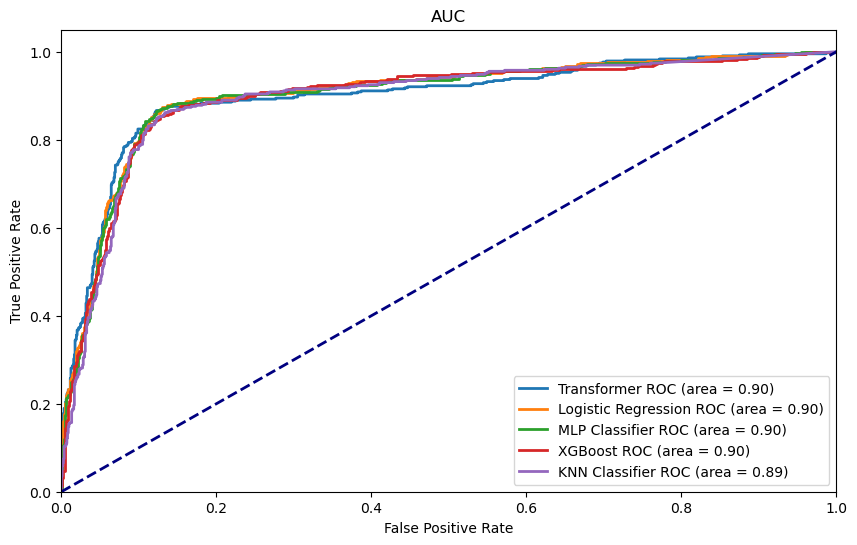

In [647]:
models = [
    ('Logistic Regression', LogisticRegression(C=8.68511373751352, penalty='l2', solver='saga', random_state=42)),
    ('MLP Classifier', MLPClassifier(max_iter= 250, learning_rate_init=0.01, solver='sgd', learning_rate= 'adaptive', hidden_layer_sizes=(30,), batch_size=143, alpha=0.3593813663804629, activation='tanh', random_state=42)), 
    ('XGBoost',XGBClassifier(random_state=19, objective='binary:logistic', eval_metric='logloss',subsample = 1.0, n_estimators=350, min_child_weight=5, max_depth=15, learning_rate=0.01)),
    ('KNN Classifier', KNeighborsClassifier(weights= 'distance', p=2, n_neighbors= 25, algorithm= 'auto')), 
]

plt.figure(figsize=(10, 6))

plt.plot(fpr_transformer, tpr_transformer, lw=2, label='Transformer ROC (area = %0.2f)' % roc_auc_transformer)

for name, model in models:
    pipeline = ImbPipeline([('model', model)])
    
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)

    y_probas = cross_val_predict(pipeline, X_combined_tfidf_val, y_val, cv=stratified_kfold, method='predict_proba')
    fpr, tpr, thresholds = roc_curve(y_val, y_probas[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='%s ROC (area = %0.2f)' % (name, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.legend(loc="lower right")
plt.show()

### Table with  model's resuslts

In [648]:
models = pd.DataFrame({'Model': ['Logistic Regression', 'KNN Classifier', 'MLP Classifier', 'XGBoost Classifier', 'DistilBERT'],
                       'F1 Score - validation': [f1_logit, f1_knn, f1_mlp, f1_xgboost, f1_distilbert],
                       'Accuracy Score - validation': [accuracy_logit, accuracy_knn, accuracy_mlp, accuracy_xgboost, accuracy_distilbert],
                       'ROC-AUC Score - validation': [roc_logit, roc_knn, roc_mlp, roc_xgboost, roc_distilbert],
                       'Precision Score - validation': [precision_logit, precision_knn, precision_mlp, precision_xgboost, precision_distilbert],
                       'Recall Score - validation': [recall_logit, recall_knn, recall_mlp, recall_xgboost, recall_distilbert]})
models.sort_values(by='F1 Score - validation', ascending=False)

,Model,F1 Score - validation,Accuracy Score - validation,ROC-AUC Score - validation,Precision Score - validation,Recall Score - validation
2,MLP Classifier,0.813288,0.895647,0.875603,0.795964,0.831382
0,Logistic Regression,0.807870,0.893726,0.869899,0.798627,0.817330
1,KNN Classifier,0.789934,0.877081,0.867210,0.741273,0.845433
4,DistilBERT,0.784897,0.879641,0.855824,0.767338,0.803279
3,XGBoost Classifier,0.780931,0.876440,0.854352,0.757709,0.805621


In [633]:
# Transform the Test data using the same vectorizers
X1_tfidf_test = tfidf_vectorizer1.transform(X1_test)
X2_tfidf_test = tfidf_vectorizer2.transform(X2_test)
X3_tfidf_test = tfidf_vectorizer3.transform(X3_test)

# Combine TF-IDF features for the validation data
X_combined_tfidf_test = hstack([X1_tfidf_test, X2_tfidf_test, X3_tfidf_test])

# Ensure that the number of features match
print(X_combined_tfidf_test.shape)  # Should output: (4686, 162797)

(695, 162797)


In [636]:
test_pred_array = mlp_model.predict(X_combined_tfidf_val)

In [639]:
test_pred = pd.Series(test_pred_array)
test_pred.to_csv('Test_predictions.csv', index=False)

In [641]:
test_pred.value_counts()

0    1116
1     446
Name: count, dtype: int64